In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
import time

In [8]:
transform = transforms.ToTensor()

In [23]:
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

In [24]:
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

In [11]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [12]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [13]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [15]:
type(train_data[0])

tuple

In [16]:
image, label = train_data[0]

In [17]:
image.shape

torch.Size([1, 28, 28])

In [18]:
label

5

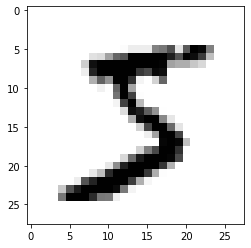

In [21]:
plt.imshow(image.reshape((28, 28)), cmap='gist_yarg')

In [25]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [26]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))

In [27]:
for images, labels in train_loader:
    break

In [28]:
images.shape

torch.Size([100, 1, 28, 28])

In [29]:
labels.shape

torch.Size([100])

Labels:  [   4    6    2    3    4    0    9    5    0    1    6    9]


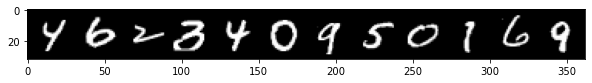

In [30]:
print('Labels: ', labels[:12].numpy())

im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

In [31]:
class MultilayerPerceptron(nn.Module):
    def __init__(self, in_sz=784, out_sz=10, layers=[120, 84]):
        super().__init__()
        self.fc1 = nn.Linear(in_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], out_sz)
    
    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [32]:
torch.manual_seed(101)
model = MultilayerPerceptron()
model

MultilayerPerceptron(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [33]:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [37]:
images.view(100, -1).shape

torch.Size([100, 784])

In [40]:
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b, (X_train, y_train) in enumerate(train_loader):
        b += 1
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if b % 200 == 0:
            acc = trn_corr.item() * 100 / (100 * b)
            print(f'Epoch {i} batch {b} loss: {loss.item()} accuracy: {acc}')
    
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            tst_corr += (predicted == y_test).sum()
    
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)


total_time = time.time() - start_time

print(f'Duration: {total_time / 60} mins')

Epoch 0 batch 200 loss: 0.22795961797237396 accuracy: 94.96
Epoch 0 batch 400 loss: 0.2516493499279022 accuracy: 95.1825
Epoch 0 batch 600 loss: 0.1338425874710083 accuracy: 95.41833333333334
Epoch 1 batch 200 loss: 0.15869462490081787 accuracy: 96.6
Epoch 1 batch 400 loss: 0.07958360016345978 accuracy: 96.6625
Epoch 1 batch 600 loss: 0.0789152979850769 accuracy: 96.73666666666666
Epoch 2 batch 200 loss: 0.15018056333065033 accuracy: 97.375
Epoch 2 batch 400 loss: 0.2058287262916565 accuracy: 97.3875
Epoch 2 batch 600 loss: 0.020933447405695915 accuracy: 97.41833333333334
Epoch 3 batch 200 loss: 0.07572457194328308 accuracy: 98.18
Epoch 3 batch 400 loss: 0.03889550268650055 accuracy: 98.06
Epoch 3 batch 600 loss: 0.07137620449066162 accuracy: 97.98
Epoch 4 batch 200 loss: 0.047837864607572556 accuracy: 98.625
Epoch 4 batch 400 loss: 0.05817914381623268 accuracy: 98.4375
Epoch 4 batch 600 loss: 0.09517595171928406 accuracy: 98.41
Epoch 5 batch 200 loss: 0.07514332234859467 accuracy: 98.

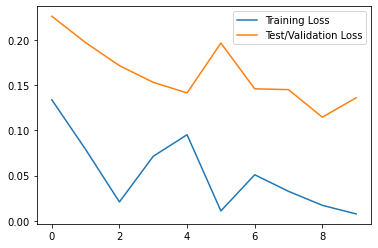

In [42]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test/Validation Loss')
plt.legend()

In [45]:
train_acc = [t / 600 for t in train_correct]

In [47]:
test_acc = [t / 100 for t in test_correct]

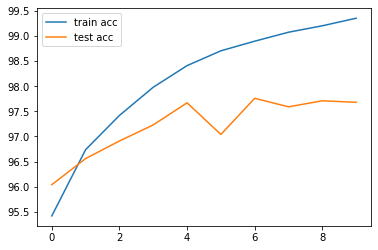

In [48]:
plt.plot(train_acc, label='train acc')
plt.plot(test_acc, label='test acc')
plt.legend()

In [49]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [50]:
with torch.no_grad():
    correct = 0
    
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [51]:
correct.item() * 100 / len(test_data)

97.68

In [52]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 972,    0,    5,    0,    2,    2,    3,    0,    6,    1],
       [   0, 1126,    2,    0,    0,    0,    3,    2,    0,    2],
       [   0,    2, 1012,    6,   10,    0,    3,   15,    9,    0],
       [   1,    2,    4,  989,    0,   18,    1,    1,    9,    1],
       [   2,    0,    2,    0,  957,    2,    3,    1,    4,   10],
       [   0,    0,    0,    0,    0,  855,    2,    0,    4,    1],
       [   2,    2,    0,    0,    2,    4,  943,    0,    2,    0],
       [   0,    1,    4,    4,    4,    4,    0, 1004,    6,   10],
       [   2,    2,    3,    0,    0,    4,    0,    2,  930,    4],
       [   1,    0,    0,   11,    7,    3,    0,    3,    4,  980]])